In [14]:
# Setup plot styling
import matplotlib.pyplot as plt
import seaborn as sns

# Reset styling to default
plt.rcdefaults()
# Grid on
plt.rcParams['axes.grid'] = True
# Top and right axis spines off
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False

# Title 18 x y labels 16 ticks 14
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
fig_w=6
fig_h=6
plt.rcParams['figure.figsize'] = (fig_w,fig_h )
# Make axis equal
plt.rcParams['axes.axisbelow'] = True 


plt.rcParams['grid.color'] = '0.8'# Grid color

# Set default color cycle
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=['#043908', '#ff7f0e', '#9467bd', '#d62728', '#364704', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'])
# Set default grid settings
plt.rcParams['grid.linestyle'] = '--'
plt.rcParams['grid.alpha'] = 0.7
plt.rcParams['font.family'] = 'sans-serif'

### 1- Psychometric function and Negative Log Likelihood functions

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# psychometric function
# define the psychometric function
def psychometric_function(intensities, lapse_rate,mu, sigma):
    # Compute Φ(intensities; μ, σ) cdf is basically sum of probablity densities 
    # until certain point intensities is the x-axis values 
    cdf = norm.cdf(intensities, loc=mu, scale=sigma) 
    # cdf is the cumulative density function kind of like the integral of the 
    # pdf of the normal distribution so when we take one intenstiy lets say 0.6 it will give us the probability of the value being less than or equal to 0.6
    p_test = lapse_rate * 0.5 + (1 - lapse_rate) * cdf # p test at intensity
    return p_test

# number of successes on a given trial number and intensity
def simpsych(lambda_, mu, sigma, intensities, trials):
	intensities = np.array(intensities)
	trials = np.array(trials)
	success_per_intensity = []
	for i in range(len(intensities)):
		p_of_level = psychometric_function(intensities[i], lambda_, mu, sigma)
		success = 0
		for j in range(trials[i]):
			rand_decision = np.random.rand()
			if rand_decision < p_of_level:
				success += 1
		success_per_intensity.append(success)
	return np.array(success_per_intensity)

# Compute log-likelihoods for each candidate mu
def log_likelihood(p_I, B, T): # likelihood of the data given the model
    # p_I is the probablity at given intensity
	# B is the number of successes PMF
	# T total number of trials
    # Add a small epsilon for numerical stability
    epsilon = 1e-9
    p_I = np.clip(p_I, epsilon, 1 - epsilon)
    return B*np.log(p_I)+(T-B)*np.log(1-p_I)

# Negative log-likelihood function (function to estimate the parameters fiting a psychometric)
def negative_log_likelihood(params, delta_dur, chose_test, total_responses):
    lambda_, mu, sigma = params
    p = psychometric_function(delta_dur, lambda_, mu, sigma)
    epsilon = 1e-9  # To prevent log(0)
    p = np.clip(p, epsilon, 1 - epsilon)
    log_likelihood = np.sum(chose_test * np.log(p) + (total_responses - chose_test) * np.log(1 - p))
    return -log_likelihood


# 1 - Fit pilot data to a psychometric function

In [132]:
# Fit real data and retrieve initial mu lambda sigma parameters
import pandas as pd
from scipy.optimize import minimize

file_path = 'data/'+'_auditory_dur_estimate_2024-12-19_01h06.07.475.csv'
# Load data
data = pd.read_csv(file_path)
print(f'Standard duration levels are {np.unique(data["standard_dur"])}')
data[:2]
min(data['delta_dur_adjusted'])

Standard duration levels are [1.   1.25 1.5  1.75]


-0.7608695652173914

We need to group the data based on the standard duration. 
Actually we have to group data in three steps:
1. Group data based on the standard duration
2. grouped data will be such that [df1200,df1400...] and we need to group each of them by the delta_dur and rise duration
3. Fit the psychometric function to each of the grouped data


In [73]:
# take each of the standard durations
data_1000ms=data[data["standard_dur"]==1.0]
data_1250ms=data[data["standard_dur"]==1.25]
data_1500ms=data[data["standard_dur"]==1.5]
data_1750ms=data[data["standard_dur"]==1.75]

assign chose test

In [82]:
for i in [data_1000ms,data_1250ms,data_1500ms,data_1750ms]:
    i.loc[:,('chose_test')]=(i['response']==i['test_order']).astype(int)



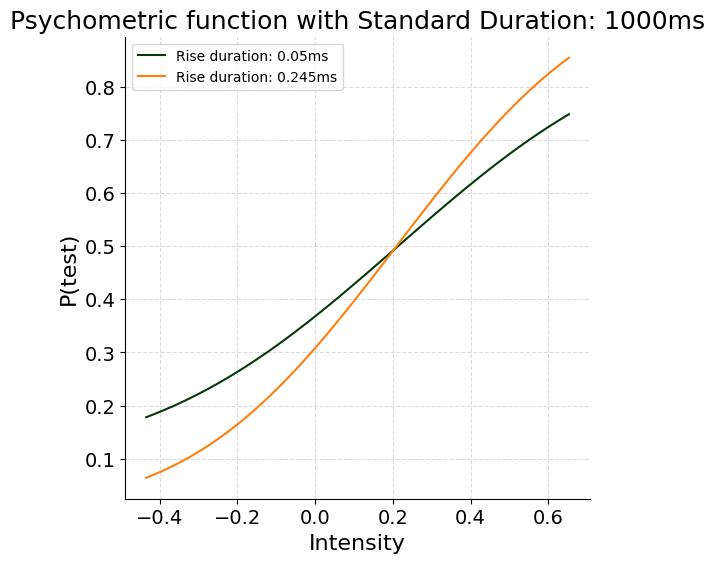

lambda: 0.01, mu: 0.20928476931975265, sigma: 0.41342598192832036


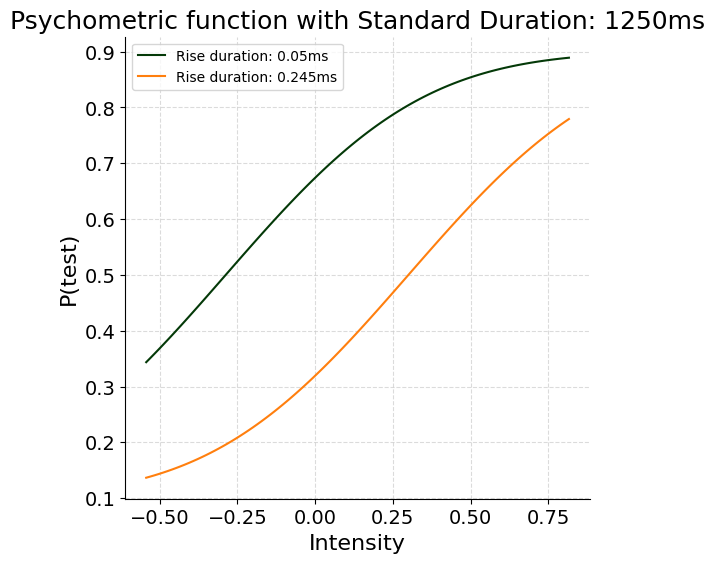

lambda: 0.2, mu: 0.3, sigma: 0.5


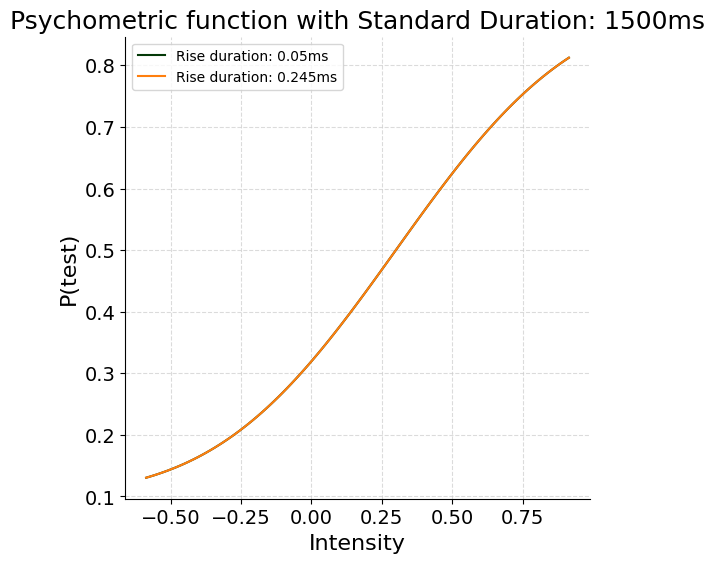

lambda: 0.2, mu: 0.3, sigma: 0.5


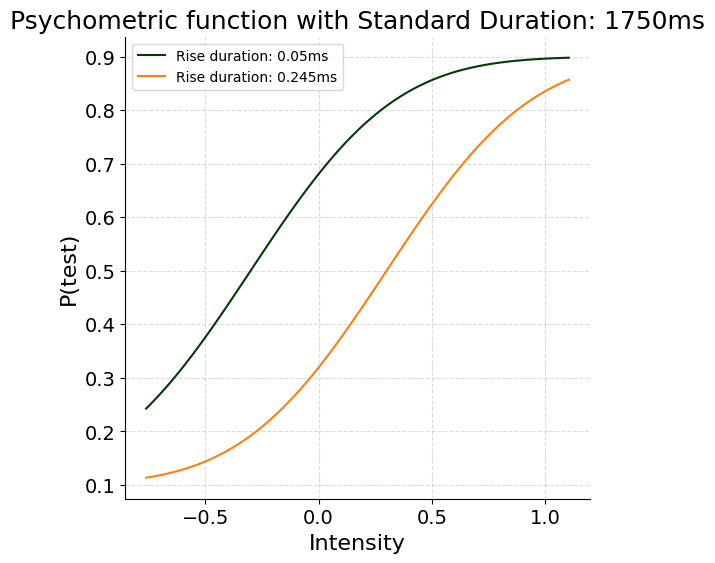

lambda: 0.2, mu: 0.3, sigma: 0.5


In [163]:
#  group each of the subgroups by rise dur and delta_dur_adjusted
data_1000ms_grouped=data_1000ms.groupby(['rise_dur','delta_dur_adjusted']).agg({'chose_test':'sum','response':'count'}).reset_index()
data_1250ms_grouped=data_1250ms.groupby(['rise_dur','delta_dur_adjusted']).agg({'chose_test':'sum','response':'count'}).reset_index()
data_1500ms_grouped=data_1500ms.groupby(['rise_dur','delta_dur_adjusted']).agg({'chose_test':'sum','response':'count'}).reset_index()
data_1750ms_grouped=data_1750ms.groupby(['rise_dur','delta_dur_adjusted']).agg({'chose_test':'sum','response':'count'}).reset_index()
data_1750ms_grouped[:2]
# fit to the psychometric function
# Fit the psychometric function to the data
def fit_psychometric_function(data_grouped):
    # Initial guess for the parameters
    initial_guess = [0.05, -0.2, 0.1]
    # bounds
    bounds = [(0.01, 0.2), (-0.3, 0.3), (0.01, 0.5)]
    # Fit the model
    result = minimize(negative_log_likelihood, initial_guess, 
                      args=(data_grouped['delta_dur_adjusted'], data_grouped['chose_test'], data_grouped['response']), bounds=bounds)
    return result.x

# plot the psychometric function
datas=[data_1000ms_grouped,data_1250ms_grouped,data_1500ms_grouped,data_1750ms_grouped]

names=['1000ms','1250ms','1500ms','1750ms']
numerator=0
for i in datas:
    # group i by rise dur
    i_grouped=i.groupby('rise_dur')
    fig, ax = plt.subplots()
    for name, group in i_grouped:
        result = fit_psychometric_function(group)
        lambda_, mu, sigma = result
        intensities = np.linspace(min(i['delta_dur_adjusted']), max(i['delta_dur_adjusted']), 100)
        p_test = psychometric_function(intensities, lambda_, mu, sigma)
        ax.plot(intensities, p_test, label=f'Rise duration: {name}ms')
    ax.set_xlabel('Intensity')
    ax.set_ylabel('P(test)')
    ax.set_title('Psychometric function with Standard Duration: '+names[numerator])
    ax.legend()
    plt.show()
    print(f'lambda: {lambda_}, mu: {mu}, sigma: {sigma}')
    numerator+=1


In [ ]:
# Step 1: Prepare the data
data['chose_test'] = (data['response'] == data['test_order']).astype(int)

# Step 2: Group by delta_dur_adjusted and rise_dur
grouped = data.groupby(['delta_dur_adjusted', 'rise_dur']).agg(
    total_responses=('response', 'count'),
    chose_test=('chose_test', 'sum')
).reset_index()

# Step 3: Calculate the proportion of "choose test" responses
grouped['p_choose_test'] = grouped['chose_test'] / grouped['total_responses']
grouped


In [28]:
# rise dur 0.05
rise_dur = 0.05
grouped_rise_dur = grouped[grouped['rise_dur'] == rise_dur]
grouped_rise_dur

,delta_dur_adjusted,rise_dur,total_responses,chose_test,p_choose_test
2,-0.586957,0.05,1,0,0.0
4,-0.543478,0.05,2,1,0.5
7,-0.458043,0.05,1,1,1.0
10,-0.425217,0.05,1,1,1.0
11,-0.420000,0.05,1,1,1.0
...,...,...,...,...,...
130,0.816522,0.05,1,1,1.0
132,0.849130,0.05,2,1,0.5
133,0.914348,0.05,2,1,0.5
135,1.028696,0.05,1,1,1.0


In [128]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import minimize
import pandas as pd

# Psychometric function
def psychometric_function(intensities, lapse_rate, mu, sigma):
    cdf = norm.cdf(intensities, loc=mu, scale=sigma) 
    p_test = lapse_rate * 0.5 + (1 - lapse_rate) * cdf 
    return p_test

# Negative log-likelihood for psychometric fit
def negative_log_likelihood(params, delta_dur, chose_test, total_responses):
    lambda_, mu, sigma = params
    p = psychometric_function(delta_dur, lambda_, mu, sigma)
    epsilon = 1e-9  # To prevent log(0)
    p = np.clip(p, epsilon, 1 - epsilon)
    log_likelihood = np.sum(chose_test * np.log(p) + (total_responses - chose_test) * np.log(1 - p))
    return -log_likelihood

# Function to fit psychometric curve to data for each rise_dur
def fit_to_psychometric(data):
    delta_dur = data['delta_dur_adjusted'].values
    chose_test = data['chose_test'].values
    total_resp = np.ones_like(chose_test)  # Each trial is a single observation

    initial_guess = [0.05, 0, 0.1]  # Initial guesses for [lambda, mu, sigma]
    bounds = [(0, 1), (-1, 1), (0.01, 1)]  # lambda ∈ [0,1], mu ∈ [-1,1], sigma > 0

    result = minimize(negative_log_likelihood, initial_guess, 
                      args=(delta_dur, chose_test, total_resp), 
                      bounds=bounds)
    lambda_hat, mu_hat, sigma_hat = result.x
    return lambda_hat, mu_hat, sigma_hat

# Load staircase data
data = pd.read_csv(file_path)

# Step 1: Prepare the data
data['chose_test'] = (data['response'] == data['test_order']).astype(int)

# Step 2: Group data by rise_dur
grouped_by_rise_dur = data.groupby('rise_dur')


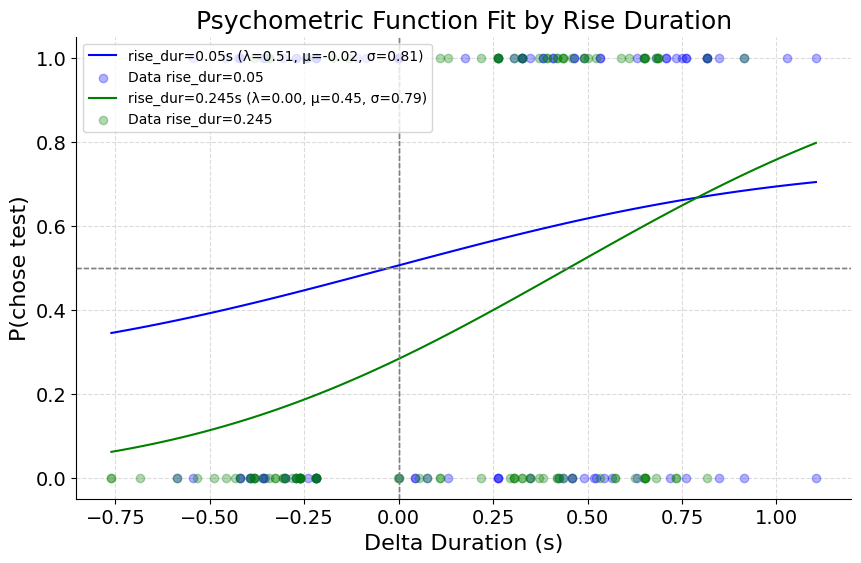

Rise Dur: 0.05 -- λ: 0.511, μ: -0.023, σ: 0.813
Rise Dur: 0.245 -- λ: 0.000, μ: 0.451, σ: 0.786


In [129]:

# Store fit results
fit_results = {}

# Plot multiple psychometric functions
plt.figure(figsize=(10, 6))

# Fit psychometric curve for each rise_dur
colors = ['blue', 'green', 'red', 'orange', 'purple']
for i, (rise_dur, group) in enumerate(grouped_by_rise_dur):
    # Fit psychometric curve to each rise_dur
    lambda_hat, mu_hat, sigma_hat = fit_to_psychometric(group)
    fit_results[rise_dur] = {'lambda': lambda_hat, 'mu': mu_hat, 'sigma': sigma_hat}

    # Plot the psychometric curve for this rise_dur
    x_fit = np.linspace(min(data['delta_dur_adjusted']), max(data['delta_dur_adjusted']), 100)
    y_fit = psychometric_function(x_fit, lambda_hat, mu_hat, sigma_hat)
    plt.plot(x_fit, y_fit, label=f'rise_dur={rise_dur}s (λ={lambda_hat:.2f}, μ={mu_hat:.2f}, σ={sigma_hat:.2f})', color=colors[i % len(colors)])

    # Plot raw data points for rise_dur
    plt.scatter(group['delta_dur_adjusted'], group['chose_test'], alpha=0.3, label=f'Data rise_dur={rise_dur}', color=colors[i % len(colors)])
    plt.axvline(x=0, color='gray', linestyle='--', linewidth=1)
    plt.axhline(y=0.5, color='gray', linestyle='--', linewidth=1)

plt.xlabel('Delta Duration (s)')
plt.ylabel('P(chose test)')
plt.title('Psychometric Function Fit by Rise Duration')
plt.legend()
plt.show()

# Print out fit results
for rise_dur, params in fit_results.items():
    print(f"Rise Dur: {rise_dur} -- λ: {params['lambda']:.3f}, μ: {params['mu']:.3f}, σ: {params['sigma']:.3f}")


# Bin data


In [6]:
rise_dur = 0.05
#binned data
grouped_by_rise_dur_bin = grouped_by_rise_dur.get_group(rise_dur)
grouped_by_rise_dur_bin

,Unnamed: 0,standard_dur,delta_dur,delta_dur_adjusted,test_dur,rise_dur,test_order,intensity,pre_dur,post_dur,isi_dur,trial_num,total_dur,response,is_correct,response_rt,chose_test
0,0,1.50,-0.001,-0.001304,1.498696,0.05,1.0,2.5,0.242334,0.240848,0.280321,1.0,3.762154,1.0,0.0,4.264452,1
1,1,1.75,0.001,0.001522,1.751522,0.05,2.0,2.5,0.267639,0.142134,0.222028,2.0,4.133288,2.0,1.0,0.133298,1
6,6,1.00,0.001,0.000870,1.000870,0.05,2.0,2.5,0.226914,0.248488,0.217926,7.0,2.694150,2.0,1.0,0.631849,1
8,8,1.25,0.001,0.001087,1.251087,0.05,1.0,2.5,0.253895,0.144116,0.233285,9.0,3.132313,2.0,0.0,1.233274,0
11,11,1.00,-0.001,-0.000870,0.999130,0.05,2.0,2.5,0.241214,0.318532,0.308636,12.0,2.867460,2.0,0.0,7.124729,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201,201,1.50,0.351,0.457826,1.957826,0.05,2.0,2.5,0.206998,0.223412,0.265841,202.0,4.154036,1.0,0.0,0.593732,0
202,202,1.50,0.376,0.490435,1.990435,0.05,2.0,2.5,0.198541,0.321148,0.219585,203.0,4.229660,2.0,1.0,0.316525,1
203,203,1.25,0.376,0.408696,1.658696,0.05,1.0,2.5,0.288847,0.253252,0.283619,204.0,3.734376,1.0,1.0,0.996165,1
205,205,1.00,0.376,0.326957,1.326957,0.05,1.0,2.5,0.317404,0.261095,0.301767,206.0,3.207166,1.0,1.0,0.722886,1


/var/folders/_p/yywkspd92qs_6p63bz38bswr0000gn/T/ipykernel_15749/1924309258.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_by_rise_dur_bin = data.groupby(['rise_dur', 'delta_dur_bin'])


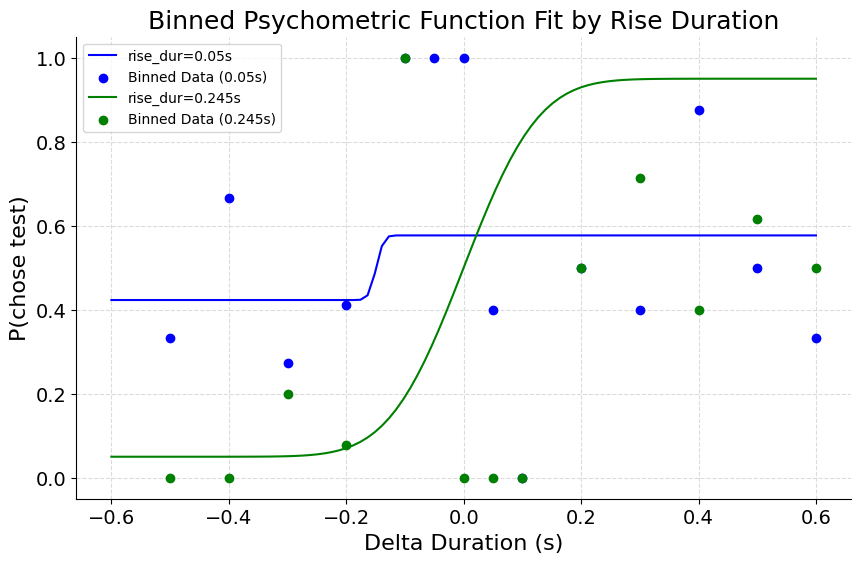

Rise Dur: 0.05 -- λ: 0.846, μ: -0.149, σ: 0.010
Rise Dur: 0.245 -- λ: 0.100, μ: 0.000, σ: 0.100


In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import minimize
import pandas as pd

# Psychometric function
def psychometric_function(intensities, lapse_rate, mu, sigma):
    cdf = norm.cdf(intensities, loc=mu, scale=sigma) 
    p_test = lapse_rate * 0.5 + (1 - lapse_rate) * cdf 
    return p_test

# Negative log-likelihood for psychometric fit
def negative_log_likelihood(params, delta_dur, chose_test, total_responses):
    lambda_, mu, sigma = params
    p = psychometric_function(delta_dur, lambda_, mu, sigma)
    epsilon = 1e-9  # To prevent log(0)
    p = np.clip(p, epsilon, 1 - epsilon)
    log_likelihood = np.sum(chose_test * np.log(p) + (total_responses - chose_test) * np.log(1 - p))
    return -log_likelihood

# Function to fit psychometric curve to binned data
def fit_to_psychometric(delta_dur, p_choose_test, total_responses):
    initial_guess = [0.1, 0, 0.1]  # Initial guesses for [lambda, mu, sigma]
    bounds = [(0, 1), (-0.5, 0.5), (0.01, 1)]  # lambda ∈ [0,1], mu ∈ [-1,1], sigma > 0

    result = minimize(negative_log_likelihood, initial_guess, 
                      args=(delta_dur, p_choose_test * total_responses, total_responses), 
                      bounds=bounds)
    lambda_hat, mu_hat, sigma_hat = result.x
    return lambda_hat, mu_hat, sigma_hat

# Load staircase data
file_path = 'data/'+'_auditory_dur_estimate_2024-12-19_01h06.07.475.csv'
data = pd.read_csv(file_path)

# Step 1: Prepare the data
data['chose_test'] = (data['response'] == data['test_order']).astype(int)

# Step 2: Create bins for delta_dur
bins = [-0.6, -0.5, -0.4, -0.3, -0.2, -0.1, -0.05, 0, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
data['delta_dur_bin'] = pd.cut(data['delta_dur_adjusted'], bins=bins, labels=['-0.5', '-0.4', '-0.3', '-0.2', '-0.1', '-0.05', '0', '0.05', '0.1', '0.2', '0.3', '0.4', '0.5', '0.6'])

# Step 3: Group data by rise_dur and delta_dur_bin
grouped_by_rise_dur_bin = data.groupby(['rise_dur', 'delta_dur_bin'])

# Step 4: Calculate p(chose test) in each bin
summary = grouped_by_rise_dur_bin.agg(
    total_responses=('response', 'count'),
    chose_test=('chose_test', 'sum')
).reset_index()
summary['p_chose_test'] = summary['chose_test'] / summary['total_responses']

# Step 5: Fit psychometric curve for each rise_dur
fit_results = {}
plt.figure(figsize=(10, 6))
colors = ['blue', 'green', 'red', 'orange', 'purple']
for i, (rise_dur, group) in enumerate(summary.groupby('rise_dur')):
    delta_dur_centers = np.array([float(label) for label in group['delta_dur_bin']])
    p_choose_test = group['p_chose_test'].values
    total_responses = group['total_responses'].values

    lambda_hat, mu_hat, sigma_hat = fit_to_psychometric(delta_dur_centers, p_choose_test, total_responses)
    fit_results[rise_dur] = {'lambda': lambda_hat, 'mu': mu_hat, 'sigma': sigma_hat}

    # Plot psychometric curve
    x_fit = np.linspace(min(bins), max(bins), 100)
    y_fit = psychometric_function(x_fit, lambda_hat, mu_hat, sigma_hat)
    plt.plot(x_fit, y_fit, label=f'rise_dur={rise_dur}s', color=colors[i % len(colors)])

    # Plot the binned data
    plt.scatter(delta_dur_centers, p_choose_test, label=f'Binned Data ({rise_dur}s)', color=colors[i % len(colors)])

plt.xlabel('Delta Duration (s)')
plt.ylabel('P(chose test)')
plt.title('Binned Psychometric Function Fit by Rise Duration')
plt.legend()
plt.show()

# Print out fit results
for rise_dur, params in fit_results.items():
    print(f"Rise Dur: {rise_dur} -- λ: {params['lambda']:.3f}, μ: {params['mu']:.3f}, σ: {params['sigma']:.3f}")


In [8]:
# binned data
summary

,rise_dur,delta_dur_bin,total_responses,chose_test,p_chose_test
0,0.050,-0.5,3,1,0.333333
1,0.050,-0.4,6,4,0.666667
2,0.050,-0.3,11,3,0.272727
3,0.050,-0.2,17,7,0.411765
4,0.050,-0.1,1,1,1.000000
5,0.050,-0.05,1,1,1.000000
6,0.050,0,2,2,1.000000
7,0.050,0.05,5,2,0.400000
8,0.050,0.1,1,0,0.000000
9,0.050,0.2,2,1,0.500000


# Staircase analysis

Fitted Parameters: lambda=0.000, mu=0.265, sigma=0.982


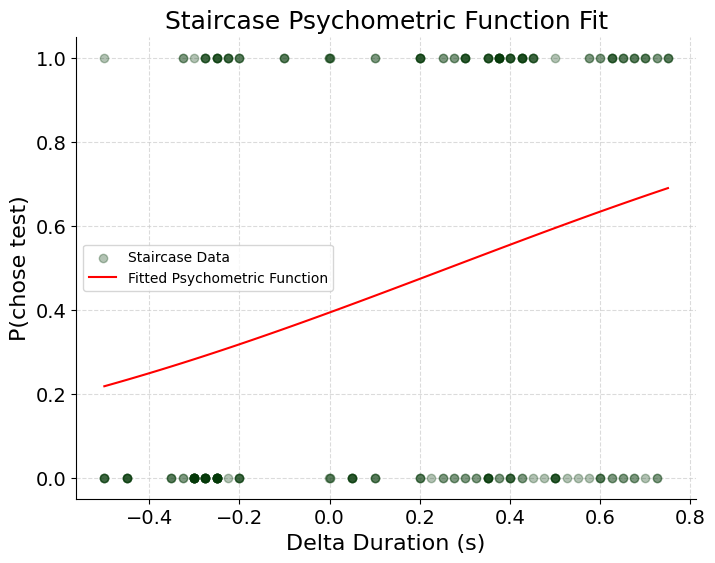

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import minimize
import pandas as pd

# Psychometric function
def psychometric_function(intensities, lapse_rate, mu, sigma):
    cdf = norm.cdf(intensities, loc=mu, scale=sigma) 
    p_test = lapse_rate * 0.5 + (1 - lapse_rate) * cdf 
    return p_test

# Negative log-likelihood for psychometric fit
def negative_log_likelihood(params, delta_dur, chose_test, total_responses):
    lambda_, mu, sigma = params
    p = psychometric_function(delta_dur, lambda_, mu, sigma)
    epsilon = 1e-9  # To prevent log(0)
    p = np.clip(p, epsilon, 1 - epsilon)
    log_likelihood = np.sum(chose_test * np.log(p) + (total_responses - chose_test) * np.log(1 - p))
    return -log_likelihood

# Function to fit psychometric curve to staircase data
def fit_to_psychometric(data):
    delta_dur = data['delta_dur'].values
    chose_test = data['chose_test'].values
    total_resp = np.ones_like(chose_test)  # Each trial is a single observation

    initial_guess = [0.05, 0, 0.1]  # Initial guesses for [lambda, mu, sigma]
    bounds = [(0, 1), (-1, 1), (0.01, 1)]  # lambda ∈ [0,1], mu ∈ [-1,1], sigma > 0

    result = minimize(negative_log_likelihood, initial_guess, 
                      args=(delta_dur, chose_test, total_resp), 
                      bounds=bounds)
    lambda_hat, mu_hat, sigma_hat = result.x
    return lambda_hat, mu_hat, sigma_hat

# Load staircase data
file_path = 'data/'+'_auditory_dur_estimate_2024-12-19_01h06.07.475.csv'
data = pd.read_csv(file_path)

# Step 1: Prepare the data
data['chose_test'] = (data['response'] == data['test_order']).astype(int)

# Step 2: Fit psychometric function
lambda_hat, mu_hat, sigma_hat = fit_to_psychometric(data)
print(f'Fitted Parameters: lambda={lambda_hat:.3f}, mu={mu_hat:.3f}, sigma={sigma_hat:.3f}')

# Step 3: Plot psychometric curve
x_fit = np.linspace(min(data['delta_dur']), max(data['delta_dur']), 100)
y_fit = psychometric_function(x_fit, lambda_hat, mu_hat, sigma_hat)

plt.figure(figsize=(8, 6))
plt.scatter(data['delta_dur'], data['chose_test'], alpha=0.3, label='Staircase Data')
plt.plot(x_fit, y_fit, label='Fitted Psychometric Function', color='red')
plt.xlabel('Delta Duration (s)')
plt.ylabel('P(chose test)')
plt.title('Staircase Psychometric Function Fit')
plt.legend()
plt.show()


### 2- simulation and data fitting

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 27.951929204093872
        x: [ 4.887e-03 -3.739e-02  1.230e-01]
      nit: 10
      jac: [ 2.414e+00 -3.006e+00  1.641e+00]
     nfev: 68
     njev: 17
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>


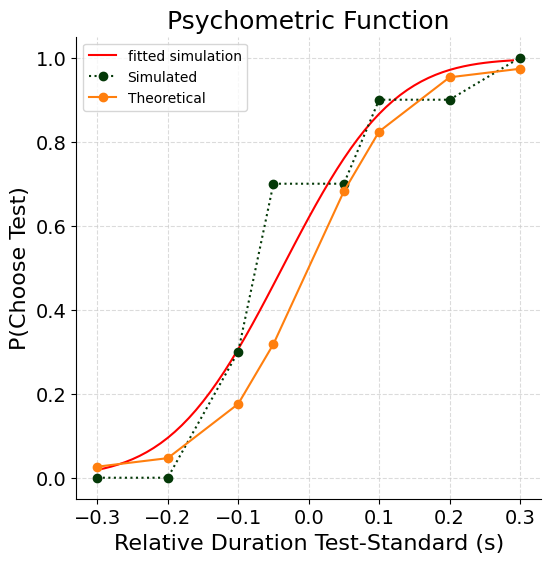

In [10]:

lambda_=0.05
mu=0
intensities = np.array([-300,-200, -100, -50, 50, 100, 200,300])/1000  # in ms, stimulus levels
n_trials=10 #n trials per intensity
T=[int(x) for x in np.ones(len(intensities))*n_trials] # number of trials for each intensity
sigma=0.1

# simulate the data
simulated_data = simpsych(lambda_,mu,sigma,intensities, T) # simulate the data number of trials for each intensity
psychometric_I=psychometric_function(intensities, lambda_,mu,sigma) # calculate the probablity of test is longer

# fit simulated_data to 
initial_guess=[0.1,0,0.1]
bounds = [(0, 1), (-1, 1), (0.01, 1)]  # Ensure sigma is positive
result = minimize(negative_log_likelihood, initial_guess, args=(intensities, simulated_data, T), bounds=bounds)
print(result)
lambda_fitted,mu_fitted,sigma_fitted = result.x
bias=mu_fitted-mu
rmse_mu=bias**2

x_fit=np.arange(-0.3,0.3,0.01)
fitted_psychometric=psychometric_function(x_fit,lambda_fitted,mu_fitted,sigma_fitted)
plt.plot(x_fit, fitted_psychometric, 'r-', label='fitted simulation')
# plot the data
plt.plot(intensities, np.array(simulated_data)/T, 'o:',label='Simulated')
plt.plot(intensities, psychometric_I, 'o-',label='Theoretical')
plt.xlabel('Relative Duration Test-Standard (s)')
plt.ylabel('P(Choose Test)')
plt.legend()
plt.title('Psychometric Function')
plt.show()


# 3- Try simulations to find best mu and sigma values for the psychometric function

Maximum Likelihood Estimate of mu: 0.0
Maximum Likelihood Estimate of sigma: 0.101


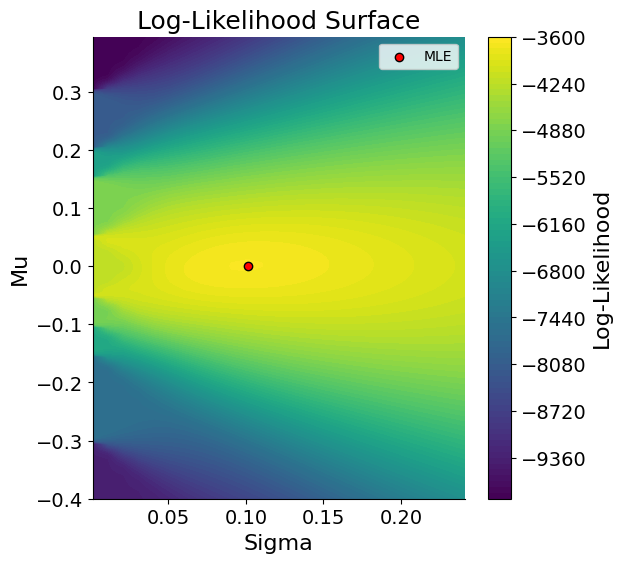

In [11]:
## 3- Try simulations to find best mu and sigma values for the psychometric function
# 3.1- Create a grid of mu and sigma values
# mu should probably be around 0 but a bit more as noise requires to have more cue for the test to be judged as longer
intensities = np.array([-300,-150, -100, -50, 50, 150, 200,300])/1000  # in ms, stimulus levels
T = [1000] * len(intensities)   # Number of trials for each intensity
mu_values=np.arange(-0.4,0.4,0.005)
sigma_values=np.arange(0.001,0.25,0.01)

lambda_prior=0.2
log_likelihood_matrix=np.zeros((len(mu_values),len(sigma_values)))

B=simpsych(lambda_prior,0,0.1,intensities,T)

# Compute log-likelihoods for each (mu,sigma) pair
for i,curr_mu in enumerate(mu_values):
    for j,curr_sigma in enumerate(sigma_values):
        p=psychometric_function(intensities,lambda_prior,curr_mu, curr_sigma)
        log_likelihood_matrix[i,j]=np.sum(log_likelihood(p,B,T))


# Find the maximum likelihood estimates (MLE) for mu and sigma
max_idx = np.unravel_index(np.argmax(log_likelihood_matrix), log_likelihood_matrix.shape)
mle_mu = mu_values[max_idx[0]]
mle_sigma = sigma_values[max_idx[1]]

print(f"Maximum Likelihood Estimate of mu: {round(mle_mu, 4)}")
print(f"Maximum Likelihood Estimate of sigma: {round(mle_sigma, 4)}")
plt.figure(figsize=(6, 6))
contour = plt.contourf(sigma_values, mu_values, log_likelihood_matrix, levels=100, cmap='viridis')
plt.colorbar(contour, label='Log-Likelihood')
plt.xlabel('Sigma')
plt.ylabel('Mu')
plt.title('Log-Likelihood Surface')
plt.scatter(mle_sigma, mle_mu, color='red', label='MLE', edgecolor='black')
plt.legend()
plt.show()



### adjust the psychometric with predictions

Maximum Likelihood Estimate of mu: -0.1
Maximum Likelihood Estimate of sigma: 0.001


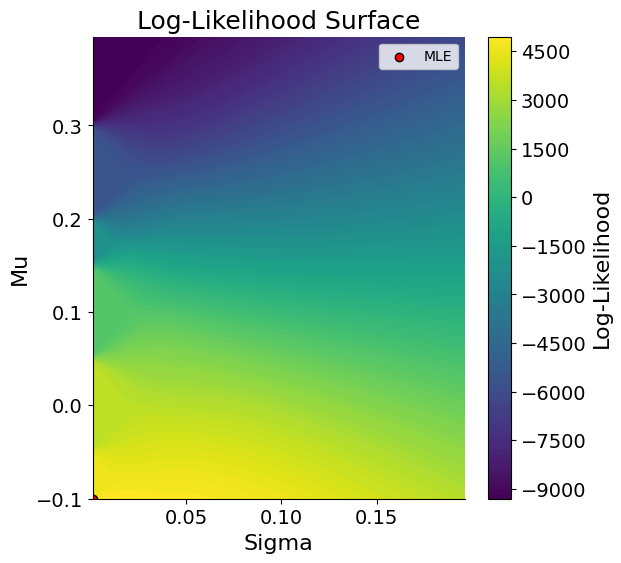

In [12]:
import numpy as np
from scipy.stats import norm

def experiment_model(intensities, lapse_rate, mu, sigma, rise_duration, weight):
    # Compute Φ(intensities; μ, σ) cdf
    cdf = norm.cdf(intensities, loc=mu, scale=sigma)
    # Adjust the probability based on rise_duration and weight
    adjusted_cdf = cdf - weight*rise_duration
    # Ensure the adjusted_cdf is within [0, 1]
    adjusted_cdf = np.clip(adjusted_cdf, 0, 1)
    p_test = lapse_rate * 0.5 + (1 - lapse_rate) * adjusted_cdf
    return p_test

# number of successes on a given trial number and intensity
def modeled_simpsych(lambda_, mu, sigma, intensities, trials, rise_duration, weight):
    intensities = np.array(intensities)
    trials = np.array(trials)
    success_per_intensity = []
    for i in range(len(intensities)):
        p_of_level = experiment_model(intensities[i], lambda_, mu, sigma, rise_duration, weight)
        success = 0
        for j in range(trials[i]):
            rand_decision = np.random.rand()
            if rand_decision < p_of_level:
                success += 1
        success_per_intensity.append(success)
    return np.array(success_per_intensity)

intensities = np.array([-300,-150, -100, -50, 50, 150, 200,300])/1000  # in ms, stimulus levels
T = [200] * len(intensities)   # Number of trials for each intensity
mu_values=np.arange(-0.1,0.4,0.005)
sigma_values=np.arange(0.001,0.2,0.005)

rise_duration=0.02
weight=0.01

lambda_prior=0.2
log_likelihood_matrix=np.zeros((len(mu_values),len(sigma_values)))

# Compute log-likelihoods for each (mu,sigma) pair
for i,curr_mu in enumerate(mu_values):
    for j,curr_sigma in enumerate(sigma_values):
        p=psychometric_function(intensities,lambda_prior,curr_mu, curr_sigma)
        #B=modeled_simpsych(lambda_prior,curr_mu,curr_sigma,intensities,T,rise_duration,weight)
        log_likelihood_matrix[i,j]=np.sum(log_likelihood(p,B,T))


        

# Find the maximum likelihood estimates (MLE) for mu and sigma
max_idx = np.unravel_index(np.argmax(log_likelihood_matrix), log_likelihood_matrix.shape)
mle_mu = mu_values[max_idx[0]]
mle_sigma = sigma_values[max_idx[1]]

print(f"Maximum Likelihood Estimate of mu: {round(mle_mu, 4)}")
print(f"Maximum Likelihood Estimate of sigma: {round(mle_sigma, 4)}")
plt.figure(figsize=(6,6))
contour = plt.contourf(sigma_values, mu_values, log_likelihood_matrix, levels=100, cmap='viridis')
plt.colorbar(contour, label='Log-Likelihood')
plt.xlabel('Sigma')
plt.ylabel('Mu')
plt.title('Log-Likelihood Surface')
plt.scatter(mle_sigma, mle_mu, color='red', label='MLE', edgecolor='black')
plt.legend()
plt.show()




### 5- Run more simulations using the real pilot data fitted parameters to get required number of trials per condition


In [13]:
result_data=fit_to_psychometric(psychometric_data_rise1)
true_lambda=0.15
true_mu=0.01
true_sigma=0.015

intensities = np.array([-200, -100, -50, 50, 100,200])/1000  # in ms, stimulus levels
trial_counts = [5, 10,20,40,60,80,100,120,140]  # Different number of trials to test

n_simulations = 1000  # Number of Monte Carlo simulations for each trial count

results = {'trials': [], 'bias_mu': [], 'var_mu': [], 'rmse_mu': []}

for num_trials in trial_counts:
    biases_mu = []
    variances_mu = []
    rmse_mu_list = []
    for sim in range(n_simulations):
        T = [num_trials] * len(intensities)
        success_per_level = simpsych(true_lambda, true_mu, true_sigma, intensities, T)
        initial_guess = [result_data[0],result_data[1],result_data[2]]  # Initial guess for lambda, mu, sigma
        bounds = [(0, 1), (-1, 1), (0.01, 1)]  # Ensure sigma is positive
        result = minimize(negative_log_likelihood, initial_guess, args=(intensities, success_per_level, T), bounds=bounds)
        lambda_hat, mu_hat, sigma_hat = result.x
        biases_mu.append(mu_hat - true_mu)
        rmse_mu_list.append((mu_hat - true_mu) ** 2)
    bias_mu = np.mean(biases_mu)
    variance_mu = np.var(biases_mu)
    rmse_mu = np.sqrt(np.mean(rmse_mu_list))
    results['trials'].append(num_trials)
    results['bias_mu'].append(bias_mu)
    results['var_mu'].append(variance_mu)
    results['rmse_mu'].append(rmse_mu)

# Plot the results
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.plot(results['trials'], results['bias_mu'], 'o-')
plt.xlabel('Number of Trials per Intensity')
plt.ylabel('Bias of mu')
plt.title('Bias of mu vs. Trials')

plt.subplot(1, 3, 2)
plt.plot(results['trials'], results['var_mu'], 'o-')
plt.xlabel('Number of Trials per Intensity')
plt.ylabel('Variance of mu')
plt.title('Variance of mu vs. Trials')

plt.subplot(1, 3, 3)
plt.plot(results['trials'], results['rmse_mu'], 'o-')
plt.xlabel('Number of Trials per Intensity')
plt.ylabel('RMSE of mu')
plt.title('RMSE of mu vs. Trials')

plt.tight_layout()
plt.show()


NameError: name 'psychometric_data_rise1' is not defined

In [ ]:
rise_05=grouped[grouped['rise_dur']==0.050]
rise_0245=grouped[grouped['rise_dur']==0.245]

for X in [rise_05,rise_0245]:

    X['p_choose_test'] = X['chose_test'] / X['total_responses']
    
    lambda_hat, mu_hat, sigma_hat = fit_psychometric_function(X)
    print(f"λ: {lambda_hat:.3f}, μ: {mu_hat:.3f}, σ: {sigma_hat:.3f}")

    x_data = X['delta_dur_adjusted']
    y_data = X['p_choose_test']
    y_data_smooth_binned = X['p_choose_test'].rolling(window=3).mean()
    bin_edges = np.histogram_bin_edges(x_data, bins=5)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    y_data_binned = np.zeros(len(bin_centers))

    for i in range(len(bin_centers)):
        bin_mask = (x_data >= bin_edges[i]) & (x_data < bin_edges[i + 1])
        y_data_binned[i] = y_data[bin_mask].mean()

    y_data_smooth_binned = pd.Series(y_data_binned)


    x_fit = np.linspace(min(X['delta_dur_adjusted']), max(X['delta_dur_adjusted']), 100)
    y_fit = psychometric_function(x_fit, lambda_hat, mu_hat, sigma_hat)
    plt.plot(x_fit, y_fit, label=f'λ={lambda_hat:.2f}, μ={mu_hat:.2f}, σ={sigma_hat:.2f}')
    plt.scatter(bin_centers, y_data_smooth_binned, alpha=0.3, label=f"Data {X['rise_dur'].iloc[0]}")
    plt.axvline(x=0, color='gray', linestyle='--', linewidth=1)
    plt.axhline(y=0.5, color='gray', linestyle='--', linewidth=1)
    plt.xlabel('Delta Duration (s)')
    plt.ylabel('P(chose test)')
    plt.title('Psychometric Function Fit')
    plt.legend()
    #plt.show()
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()